In [1]:
import pandas as pd
import numpy as np
import timeit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib import colors

import scipy.stats

%matplotlib inline

In [2]:
import plot
import calculate

In [3]:
#this defines the criterion which we use to filter authors
CAREER_LENGTH = 10 
END_YEAR = 2018
MAX_CAREER_LENGTH_COHORT = 15    # this defines how long we follow each cohort


In [4]:
# Publication data
authorPublicationData = pd.read_csv('derived-data/author-publications-atleast-'+str(CAREER_LENGTH)+'-year.csv')
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count()

print("authorPublicationData no duplicates: ", authorPublicationData.shape[0])

#print(authorPublicationData.head())


authorPublicationData no duplicates:  5898126


In [5]:
credible_authors = pd.read_csv('derived-data/authors-scientific-atleast-'+ str(CAREER_LENGTH) + '-year-extended.csv', encoding='utf-8')

In [6]:
credible_authors = credible_authors.set_index('start_year')

print("credible_authors: ", credible_authors.shape[0])
print(credible_authors.head())

#print(credible_authors[credible_authors['author'] == 'donatella sciuto'])
credible_authors.rename(columns={'num_pub':'total_num_pub'}, inplace=True)



credible_authors:  255696
                      author  end_year  num_pub  career_length  max_absence  \
start_year                                                                    
2001        'maseka lesaoana      2015        2             15           14   
1992         a aart blokhuis      2005        2             14           13   
1979              a min tjoa      2017      191             39            7   
1992        a-imam al-sammak      2006        3             15           13   
1998              a-xing zhu      2017       22             20            5   

            avg_absence  dropped_after_10 gender  early_career_qual  \
start_year                                                            
2001          14.000000              True   none               23.0   
1992          13.000000              True   none                0.0   
1979           1.071429             False   none                0.0   
1992           7.000000              True      m                0

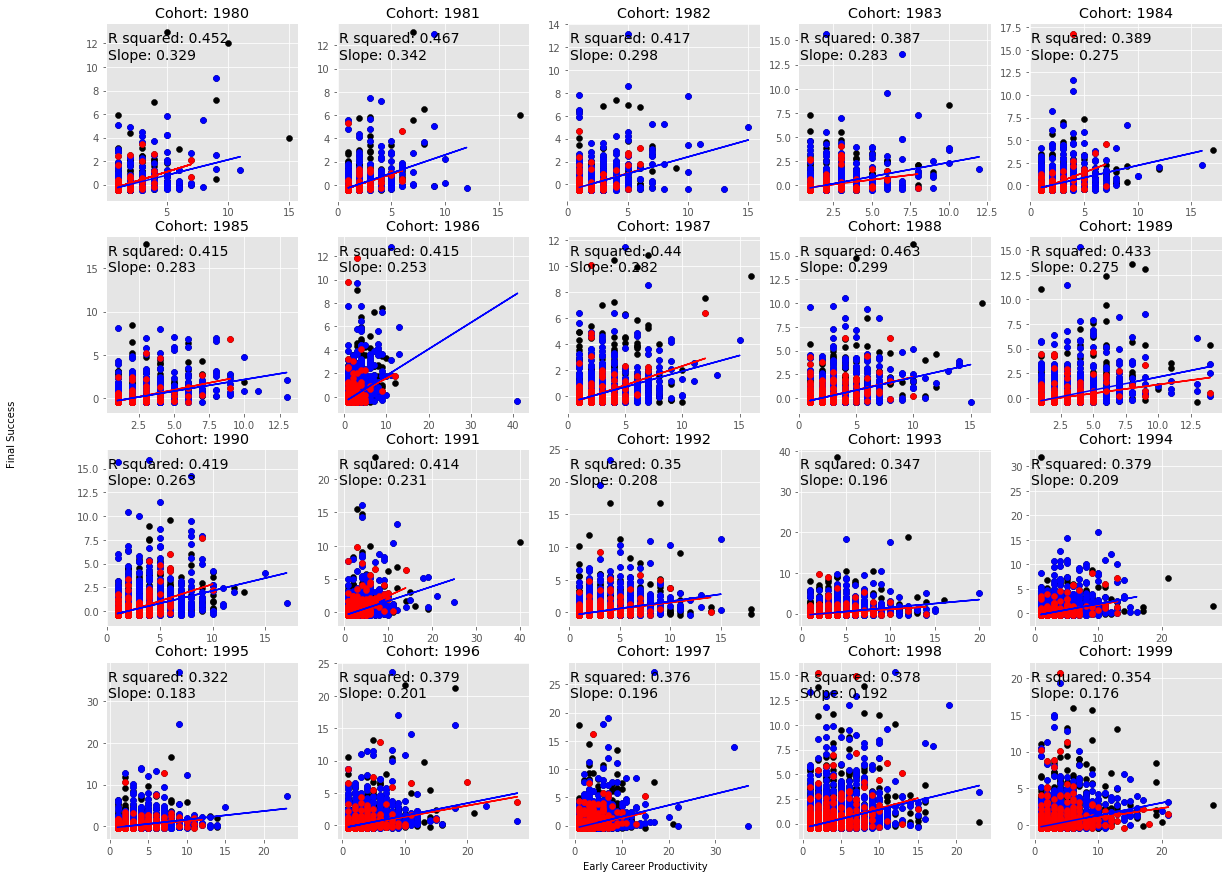

   year num_obs  group     slope  intercept   r_value       p_value   std_err
0  1980    1221    all  0.329089  -0.591067  0.451887  1.745563e-62  0.018607
1  1980     705    men  0.262484  -0.511806  0.420498  1.407186e-31  0.021360
2  1980      96  women  0.321950  -0.524700  0.488138  4.535921e-07  0.059372
3  1981    1381    all  0.342297  -0.611475  0.467133  8.829869e-76  0.017447
4  1981     789    men  0.314129  -0.563971  0.440390  9.175180e-39  0.022828


In [7]:
from matplotlib.lines import Line2D

zscore = True
numcols = 5
start_range = 1980
end_range = 2000
cells = end_range - start_range
numrows = int(cells/numcols)

var = "prod" # can also be qual

results = pd.DataFrame(columns=["year", "num_obs", "group", "slope", "intercept", "r_value", "p_value", "std_err"])
fig, ax = plt.subplots(nrows=numrows, ncols=numcols, sharex=False, sharey=False, figsize=(20,15))


custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='black', lw=4)]
for year in range(start_range, end_range):
    data = credible_authors.loc[year]
    x = data['early_career_prod']
    
    
    if(zscore):
        y = (data['succ_after_15y']-np.mean(data['succ_after_15y']))/np.std(data['succ_after_15y'])
    else:
        y = data['succ_after_15y']/np.sum(data['succ_after_15y'])
   
    x_f = data[data.gender == 'f']['early_career_prod']
    if(zscore):
        y_f = (data[data.gender == 'f']['succ_after_15y']-np.mean(data['succ_after_15y']))/np.std(data['succ_after_15y'])
    else:
        y_f = data[data.gender == 'f']['succ_after_15y']/np.sum(data['succ_after_15y'])
    
    x_m = data[data.gender == 'm']['early_career_prod']
    if(zscore):
        y_m = (data[data.gender == 'm']['succ_after_15y']-np.mean(data['succ_after_15y']))/np.std(data['succ_after_15y'])
    else:
        y_m = data[data.gender == 'm']['succ_after_15y']/np.sum(data['succ_after_15y'])
    

    axes = ax[(year-start_range)//numcols,year%start_range%numcols]
    axes.scatter(x, y, color="black")
    axes.scatter(x_m, y_m, color="blue")
    axes.scatter(x_f, y_f, color="red")
    fit = np.polyfit(x, y, deg=1)
    fit_f = np.polyfit(x_f, y_f, deg=1)
    fit_m = np.polyfit(x_m, y_m, deg=1)
    #axes.plot(x, fit[0] * x + fit[1], color='black')
    axes.plot(x_f, fit_f[0] * x_f + fit_f[1], color='red')
    axes.plot(x_m, fit_m[0] * x_m + fit_m[1], color='blue')
    axes.set_title("Cohort: " + str(year))
    # plt.xlim(0, 50)
    # plt.ylim(0,200)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    results = results.append({"year":year, "num_obs":len(x), "group":"all", "slope":slope, "intercept":intercept, 
                              "r_value":r_value, "p_value":p_value, "std_err":std_err}, ignore_index=True)
    
    m_slope, m_intercept, m_r_value, m_p_value, m_std_err = scipy.stats.linregress(x_m, y_m)
    results = results.append({"year":year, "num_obs":len(x_m), "group":"men", "slope":m_slope, "intercept":m_intercept, 
                              "r_value":m_r_value, "p_value":m_p_value, "std_err":m_std_err}, ignore_index=True)
    f_slope, f_intercept, f_r_value, f_p_value, f_std_err = scipy.stats.linregress(x_f, y_f)
    results = results.append({"year":year, "num_obs":len(x_f), "group":"women", "slope":f_slope, "intercept":f_intercept, 
                              "r_value":f_r_value, "p_value":f_p_value, "std_err":f_std_err}, ignore_index=True)
    
    #print(slope, intercept)
    #axes.add_artist(axes.legend("R squared: " + str(r_value), loc=2))
    axes.annotate("R squared: " + str(np.round(r_value, decimals=3))+"\nSlope: "+str(np.round(slope, decimals=3)), xy=(0.01,0.8), xycoords='axes fraction', fontsize=14)
    #axes.legend(custom_lines, ['Female', 'Male', 'All'], loc=1)
fig.text(0.5, 0.1, 'Early Career Productivity', ha='center', va='center')
fig.text(0.06, 0.5, 'Final Success', ha='center', va='center', rotation='vertical')
plt.show()
if(zscore):
    fig.savefig("fig/earlycareer_"+str(var)+"_final_success_zscore.png", edgecolor='none', bbox_inches='tight')
else:
    fig.savefig("fig/earlycareer_"+str(var)+"_final_success.png", edgecolor='none', bbox_inches='tight')

print(results.head())
if(zscore):
    results.to_csv("fig/earlycareer_"+str(var)+"_final_success_zscore.csv")
else:
    results.to_csv("fig/earlycareer_"+str(var)+"_final_success.csv")

In [8]:
results[results.year==1985]

,year,num_obs,group,slope,intercept,r_value,p_value,std_err
15,1985,2361,all,0.283183,-0.550534,0.415084,5.384434e-99,0.012779
16,1985,1388,men,0.269423,-0.531406,0.432412,2.475765e-64,0.015091
17,1985,173,women,0.323513,-0.651018,0.518036,2.892076e-13,0.040849


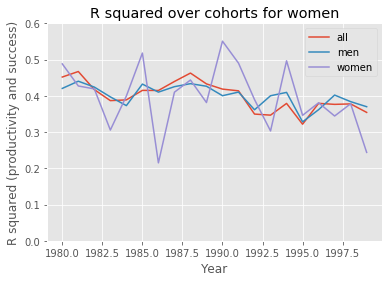

In [9]:
for group in ['all', 'men', 'women']:
    temp = results[results.group == group]
    plt.plot(temp['year'], temp['r_value'], label=group)
plt.xlabel("Year")
plt.ylabel("R squared (productivity and success)")
plt.title("R squared over cohorts for " + group)
plt.ylim((0,0.6))
plt.legend()
plt.show()

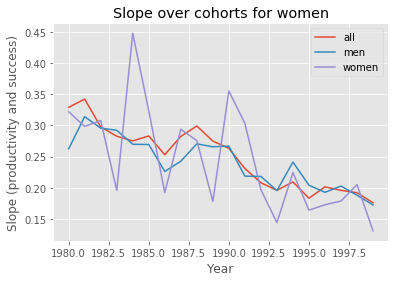

In [10]:
for group in ['all', 'men', 'women']:
    temp = results[results.group == group]
    plt.plot(temp['year'], temp['slope'], label=group)
plt.xlabel("Year")
plt.ylabel("Slope (productivity and success)")
plt.title("Slope over cohorts for " + group)
plt.legend()
plt.show()

In [11]:
results.head()

,year,num_obs,group,slope,intercept,r_value,p_value,std_err
0,1980,1221,all,0.329089,-0.591067,0.451887,1.745563e-62,0.018607
1,1980,705,men,0.262484,-0.511806,0.420498,1.407186e-31,0.021360
2,1980,96,women,0.321950,-0.524700,0.488138,4.535921e-07,0.059372
3,1981,1381,all,0.342297,-0.611475,0.467133,8.829869e-76,0.017447
4,1981,789,men,0.314129,-0.563971,0.440390,9.175180e-39,0.022828


In [12]:
credible_authors.reset_index(inplace=True)

In [13]:
# #print(credible_authors.head(n=1))
# credible_authors[credible_authors['author'] == 'donatella sciuto'].head(5)

# #print("-----------------------------------------")
# #print(authorPublicationData.head(n=1))

# authorPublicationData[authorPublicationData['author'] == 'donatella sciuto'].head(5)


temp = authorPublicationData.groupby(['year','author']).count().reset_index()
temp = temp.rename(columns={'pub_id':'num_pub'}, inplace=False)

# #print(temp[temp['author'] == 'donatella sciuto'].head(3))


authorPublicationData = temp.merge(credible_authors, how="inner", on=["author"])

# print(authorPublicationData[authorPublicationData['author'] == 'donatella sciuto'].head(3))

# authorPublicationData.shape



groupByYearData = calculate.groupDataAndCalculateCumulativeValues(authorPublicationData, 1, 'num_pub')

# #print(np.unique(groupByYearData['gender']))
authorPublicationData['gender'] = authorPublicationData['gender'].fillna('none')


years = groupByYearData['year'].unique()
years = sorted(years)

cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LENGTH_COHORT)]



In [14]:
# # here is a bug; total_num_pub of this author is 349; num_pub and cum_num_pub should only contain publications in "year"
#print(groupByYearData.head(n=1))
# print(np.unique(groupByYearData["year"]))

print(groupByYearData[groupByYearData['author'] == '\'maseka lesaoana'].head(10))
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
print(groupByYearData[groupByYearData['author'] == '(max) zong-ming cheng'].head(10))

#print(groupByYearData.sort_values(by=['author', 'year']).head())

         year            author  num_pub  start_year  end_year  total_num_pub  \
448881   2001  'maseka lesaoana        1        2001      2015              2   
2029249  2015  'maseka lesaoana        1        2001      2015              2   

         career_length  max_absence  avg_absence  dropped_after_10 gender  \
448881              15           14         14.0              True   none   
2029249             15           14         14.0              True   none   

         early_career_qual  early_career_recognition  succ_after_15y  \
448881                23.0                       5.0            23.0   
2029249               23.0                       5.0            23.0   

         early_career_prod  cum_num_pub  
448881                   1            1  
2029249                  1            2  
Empty DataFrame
Columns: [year, author, num_pub, start_year, end_year, total_num_pub, career_length, max_absence, avg_absence, dropped_after_10, gender, early_career_qual, early_car

In [15]:
from importlib import reload
reload(plot)

<module 'plot' from '/home/danielkostic/cumulative-advantage/plot.py'>

In [16]:
cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", credible_authors)

#------------------------------------------
# some plausibility checks
print(cohort_careerage_df.head(n=1))
subset1 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 1) & (cohort_careerage_df.gender == "all")]
vals1 = subset1["values"]

subset10 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 10) & (cohort_careerage_df.gender == "all")]
vals10 = subset10["values"]

from collections import Counter

print(type(vals1))
print(Counter(vals1.values[0]))
print(len(vals1.values[0]))


print(type(vals10))
print(Counter(vals10.values[0]))
print(len(vals10.values[0]))


  cohort_start_year career_age criterion gender  \
0              1970          1   num_pub    all   

                                              values  
0  [1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, ...  
<class 'pandas.core.series.Series'>
Counter({1.0: 4914, 2.0: 622, 3.0: 118, 4.0: 37, 5.0: 9, 6.0: 3, 8.0: 2, 9.0: 1})
5706
<class 'pandas.core.series.Series'>
Counter({0.0: 3371, 1.0: 1146, 2.0: 513, 3.0: 262, 4.0: 146, 5.0: 99, 6.0: 72, 7.0: 27, 8.0: 24, 9.0: 12, 10.0: 11, 11.0: 8, 15.0: 3, 14.0: 2, 19.0: 2, 13.0: 2, 12.0: 1, 22.0: 1, 27.0: 1, 17.0: 1, 29.0: 1, 20.0: 1})
5706


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


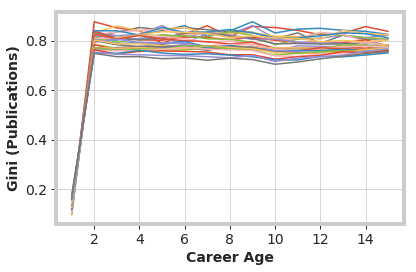

plot_cohort_size_gini_cor ---  unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


NameError: name 'prints' is not defined

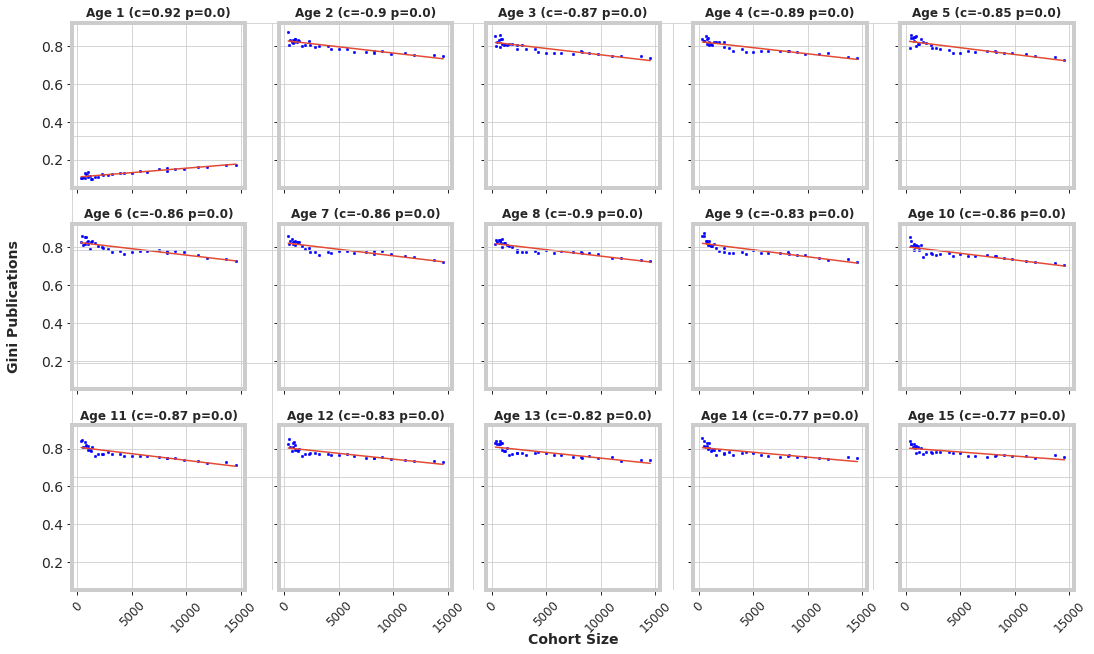

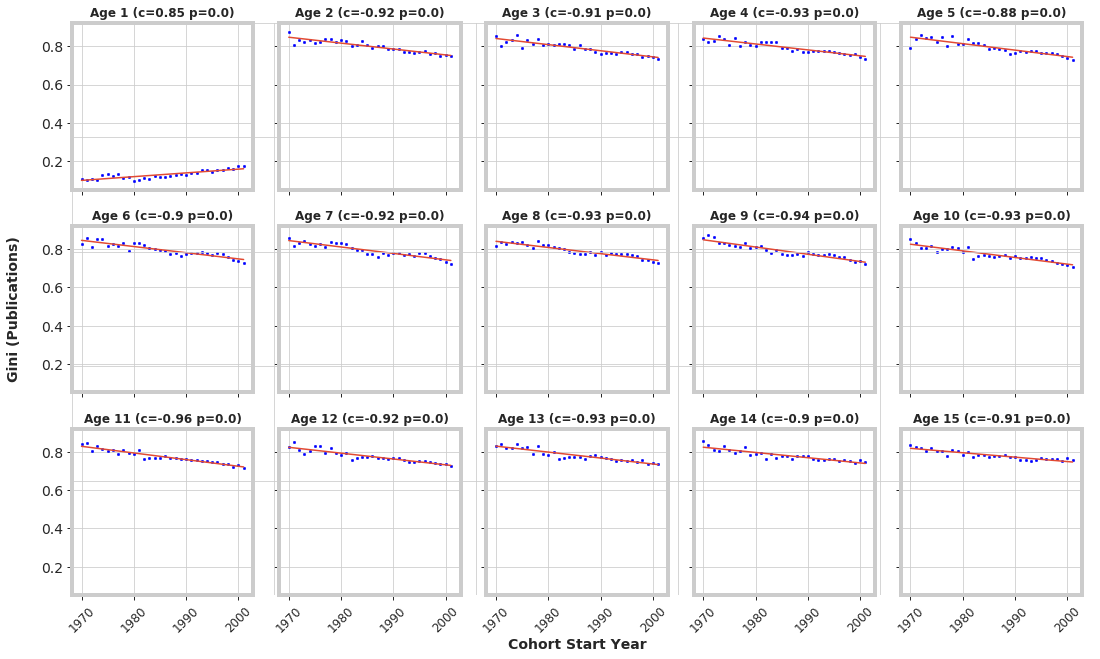

In [17]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", "Publications", credible_authors)  

In [ ]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "cum_num_pub", "Cumulative Publications", credible_authors)  